# Import packages

In [2]:
import pickle  # Local Python (3.8) is fine with this. If you're suing Google
# colab, which uses a Python version of 3.6, you need to do import pickel5
# as pickle
import cloudpickle as cp
from urllib.request import urlopen

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.cluster import MiniBatchKMeans
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.combine import SMOTEENN

from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from collinearity import SelectNonCollinear

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,
    make_scorer


# Custom functions

In [3]:
from dataset_expansion import dataset_feature_expansion, merge_multiple_dfs
from dataset_cleanup import filter_low_variance
from dataset_plot import simple_pie_plot
from pickle_managment import save_pickle, load_pickle


Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


# Read in data

## Regression

In [ ]:
regression_df = pd.read_csv('datasets\cleaned_datasets\BBB_regression.csv')
regression_df

In [ ]:
(regression_df['logBB'] <= -1.01).sum()  #These are BBB-

In [ ]:
(regression_df['logBB'] >= -1).sum()  #These are BBB+

## Classification

In [ ]:
classification_df = pd.read_csv(
    'datasets\cleaned_datasets\BBB_classification.csv'
)
classification_df

In [ ]:
classification_df['BBB+/BBB-'].value_counts()

# Dataset expansion & cleaning
Major expansion steps:
1. Add in RDKit descriptors
2. Add in Morgan fingerprints
3. Add in MACCS keys

Major cleaning steps:
1. Remove columns whose variance is 0--all values are hte same
    * Done by a function so later the threshold for filtering
    based on variance level is adjustable

## Regression

In [ ]:
regression_df_expanded, regression_expansion_errors = dataset_feature_expansion(
    regression_df)
regression_df_expanded  #Missing SMILES are the chemicals that have errors
# when going through the calculations

In [ ]:
regression_df_expanded_cleaned = filter_low_variance(
    regression_df_expanded,
    exclude_col_list=['SMILES', 'logBB'],
    threshold_level=0
)
regression_df_expanded_cleaned

In [ ]:
regression_df_expanded_cleaned.to_csv(
    'datasets\expanded_datasets\BBB_regression_expanded.csv.zip',
    index=False,
    compression='zip'  # Have to use zip here since the classification
    # dataset will become very large. Zipped .csv files can be directly read
    # by pd.read_csv()
)
print('Done!')

## Classification

In [ ]:
classification_df_expanded, classification_expansion_errors = dataset_feature_expansion(
    classification_df)
classification_df_expanded

In [ ]:
classification_df_expanded_cleaned = filter_low_variance(
    classification_df_expanded,
    exclude_col_list=['SMILES', 'BBB+/BBB-'],
    threshold_level=0
)
classification_df_expanded_cleaned

In [ ]:
classification_df_expanded_cleaned.to_csv(
    'datasets\expanded_datasets\BBB_classification_expanded.csv.zip',
    index=False,
    compression='zip'
)
print('Done!')

# Dataset rebalance
Before center and standardization

## Regression
Regression dataset doesn't need rebalancing

## Classification

In [ ]:
classification_df_expanded_cleaned = pd.read_csv(
    'datasets\expanded_datasets\BBB_classification_expanded.csv.zip')
classification_df_expanded_cleaned

In [ ]:
classification_BBB_N = (classification_df_expanded_cleaned
[classification_df_expanded_cleaned['BBB+/BBB-'] == 'BBB-']).shape[0]  #These
# are BBB-
classification_BBB_Y = (classification_df_expanded_cleaned
[classification_df_expanded_cleaned['BBB+/BBB-'] == 'BBB+']).shape[0]  #These
# are BBB+

simple_pie_plot(
    label_list=['BBB-', 'BBB+'],
    num_list=[classification_BBB_N, classification_BBB_Y],
    title_str='Composition of 2 categories in regression dataset before balancing'
)
plt.show()

In [ ]:
X = classification_df_expanded_cleaned.loc[
    :,
    ~classification_df_expanded_cleaned.columns.isin(['SMILES', 'BBB+/BBB-'])
    ]
y = classification_df_expanded_cleaned['BBB+/BBB-']

### Under-sampling by ClusterCentroids

In [ ]:
cluster_centroids = ClusterCentroids(
    estimator=MiniBatchKMeans(n_init=1, random_state=1),
    random_state=1
)

X_resample, y_resample = cluster_centroids.fit_resample(X, y)

classification_df_after_centroid_balancing = merge_multiple_dfs(
    df_list=[classification_df_expanded_cleaned['SMILES'], y_resample,
             X_resample])
classification_df_after_centroid_balancing

In [ ]:
classification_BBB_N = (classification_df_after_centroid_balancing
[classification_df_after_centroid_balancing['BBB+/BBB-'] == 'BBB-']).shape[
    0]  #These
# are BBB-
classification_BBB_Y = (classification_df_after_centroid_balancing
[classification_df_after_centroid_balancing['BBB+/BBB-'] == 'BBB+']).shape[
    0]  #These
# are BBB+

simple_pie_plot(
    label_list=['BBB-', 'BBB+'],
    num_list=[classification_BBB_N, classification_BBB_Y],
    title_str='Composition of 2 categories in regression dataset after '
              'balancing by centroids method'
)
plt.show()

In [ ]:
classification_df_after_centroid_balancing.to_csv(
    r'datasets\balanced_datasets\BBB_classification_balanced_centroid.csv.zip',
    index=False,
    compression='zip'
)
print('Done!')

### Over-sample by SMOTE then cleaning using ENN
Not using SMOTE only to create lots of hypothetical chemicals that might
not exist

In [ ]:
smoteenn = SMOTEENN(random_state=1)

X_resample, y_resample = smoteenn.fit_resample(X, y)

classification_df_after_smoteenn_balancing = merge_multiple_dfs(
    df_list=[classification_df_expanded_cleaned['SMILES'], y_resample,
             X_resample])
classification_df_after_smoteenn_balancing

In [ ]:
classification_BBB_N = (classification_df_after_smoteenn_balancing
[classification_df_after_smoteenn_balancing['BBB+/BBB-'] == 'BBB-']).shape[
    0]  #These
# are BBB-
classification_BBB_Y = (classification_df_after_smoteenn_balancing
[classification_df_after_smoteenn_balancing['BBB+/BBB-'] == 'BBB+']).shape[
    0]  #These
# are BBB+

simple_pie_plot(
    label_list=['BBB-', 'BBB+'],
    num_list=[classification_BBB_N, classification_BBB_Y],
    title_str='Composition of 2 categories in regression dataset after '
              'balancing by SMOTE-ENN method'
)
plt.show()

In [ ]:
classification_df_after_smoteenn_balancing.to_csv(
    r'datasets\balanced_datasets\BBB_classification_balanced_smoteenn.csv.zip',
    index=False,
    compression='zip'
)
print('Done!')

# Model training
Datasets transformation will be done along the way

## Regression

In [4]:
regression_df_expanded_cleaned = pd.read_csv(
    'datasets\expanded_datasets\BBB_regression_expanded.csv.zip'
)
regression_df_expanded_cleaned

,SMILES,logBB,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,...,157_y,158_y,159_y,160_y,161_y,162_y,163_y,164_y,165_y,166_y
0,CN1C(=NN=N1)SCC2=C(N3C(C(C3=O)(NC(=O)C(C4=CC=C...,-2.52,13.190522,13.190522,0.042537,-2.144257,0.133795,22.000000,520.480,500.320,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,CN1CC[C@]23[C@@H]4[C@H]1CC5=C2C(=C(C=C5)OC6[C@...,-2.15,11.445328,11.445328,0.165306,-1.798901,0.346256,45.303030,461.467,434.251,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,CN1CC[C@]23[C@@H]4[C@H]1CC5=C2C(=C(C=C5)O)O[C@...,-2.09,11.479044,11.479044,0.060963,-1.790095,0.359144,45.393939,461.467,434.251,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,CC1=NC=C(C=C1)CC2CNC(NC2=O)NCCCCC3=NC=C(C=C3C)Br,-1.88,12.391214,12.391214,0.061101,-0.159783,0.543803,19.464286,446.393,418.169,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,c1(c2c3n(c4c(C(N(C)C3)=O)c(Cl)ccc4)cn2)noc(C(O...,-1.82,12.699094,12.699094,0.092039,-2.255140,0.648321,14.192308,375.772,361.660,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1046,C[NH2+]CCCN1C2=CC=CC=C2CCC3=CC=CC=C31,1.20,2.515046,2.515046,1.095602,1.095602,0.843816,13.550000,267.396,244.212,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
1047,CN(C)CCCN1C2=CC=CC=C2SC3=CC=CC=C31,1.23,2.462963,2.462963,1.062269,1.062269,0.828858,13.250000,284.428,264.268,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
1048,CN(C)CCOC(C1=CC=CC=C1)C2=CC=CC=C2,1.30,6.083380,6.083380,0.016065,0.016065,0.784550,11.157895,255.361,234.193,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1049,CNCCCN1C2=CC=CC=C2SC3=C1C=C(C=C3)Cl,1.40,6.182100,6.182100,0.793840,0.793840,0.834133,13.000000,304.846,287.710,...,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0


In [5]:
regression_X = regression_df_expanded_cleaned.loc[
               :,
               ~regression_df_expanded_cleaned.columns.isin(
                   ['SMILES', 'logBB'])
               ]

regression_y = regression_df_expanded_cleaned['logBB']

regression_X_train, regression_X_test, regression_y_train, regression_y_test = train_test_split(
    regression_X,
    regression_y,
    test_size=0.2,
    random_state=1,
    shuffle=True
)

### Random forest

#### Model training

In [ ]:
start_time = datetime.now()

rf_regressor = RandomForestRegressor(
    random_state=1
)

rf_regressor_grid_search = GridSearchCV(
    estimator=rf_regressor,
    param_grid={
        'n_estimators': list(range(500, 2000, 400)),  #Number of trees
        'max_depth': [10, 20],  #The maximum depth of the tree
        # 'min_samples_split': [2, 5], #The minimum number of samples required to split an internal node
        # 'min_samples_leaf': [1, 2], #The minimum number of samples required to be at a leaf node
        # 'criterion': ['squared_error'] # “squared_error” for the mean
        # squared error. This is the default
    },
    cv=2,  #Number of fold for cross validation. It should be 8 or 10
    scoring={
        # All these are only viable in the negative option
        'MAE': 'neg_mean_absolute_error',
        'MSE': 'neg_mean_squared_error',
        'R2': 'r2'
    },
    refit='R2',

    n_jobs=1,
    # -1 means using all processors, but it won't give you any messages.
    # Only using 1 for my computer print out the training messages

    verbose=10  #Provide detailed more messages
)

rf_regressor_grid_search.fit(regression_X_train, regression_y_train)

end_time = datetime.now()
print('GridSearchCV took {}', end_time - start_time)

In [ ]:
rf_regressor_results_df = pd.DataFrame(rf_regressor_grid_search.cv_results_)
#Make the GridSearch results into a df
rf_regressor_results_df.drop(
    list(rf_regressor_results_df.filter(regex='time|split|std')),
    axis=1,
    inplace=True
)  # Remove columns that aren't very interesting

rf_regressor_results_df = rf_regressor_results_df.sort_values(
    by='rank_test_R2')
rf_regressor_results_df

In [ ]:
rf_regressor_results_df.to_csv(
    r'model_grid_search\random_forest_regressor\results.csv',
    index=False
)

In [ ]:
best_rf_regressor = rf_regressor_grid_search.best_estimator_
save_pickle(
    best_rf_regressor,
    r'model_pickles\random_forest_regressor\best_rf_regressor.pkl'
)
# To load this best model again, use load_pickle(r'model_pickles\random_forest_regressor\best_rf_regressor.pkl')

#### Model interpretation

In [6]:
best_rf_regressor = load_pickle(
    r'model_pickles\random_forest_regressor\best_rf_regressor.pkl')

In [7]:
importance = best_rf_regressor.feature_importances_.copy()  #Length of
# importance should be the same as your regression_X_train's number of features
non_zero_index_list = [i for i, v in enumerate(importance) if v != 0]  #Only
# care about the important ones


non_zero_feature_names = [regression_X_train.columns[i] for i in
                          non_zero_index_list]
non_zero_importance = [importance[i] for i in non_zero_index_list]

non_zero_importance_df = pd.DataFrame(
    data=dict(
        zip(
            ['Features', 'Importance'],
            [non_zero_feature_names, non_zero_importance]
        )
    )
)

non_zero_importance_df = non_zero_importance_df.sort_values(
    by='Importance',
    ascending=False
)
non_zero_importance_df = non_zero_importance_df.reset_index(drop=True)  #Reset
# the index and drop the old index
non_zero_importance_df = non_zero_importance_df.head(20)
non_zero_importance_df

,Features,Importance
0,TPSA,0.392401
1,PEOE_VSA6,0.016216
2,BCUT2D_MWLOW,0.013883
3,VSA_EState7,0.013079
4,EState_VSA6,0.012865
5,MinAbsPartialCharge,0.011339
6,MolLogP,0.010872
7,EState_VSA8,0.009033
8,EState_VSA5,0.007849
9,FpDensityMorgan3,0.007838


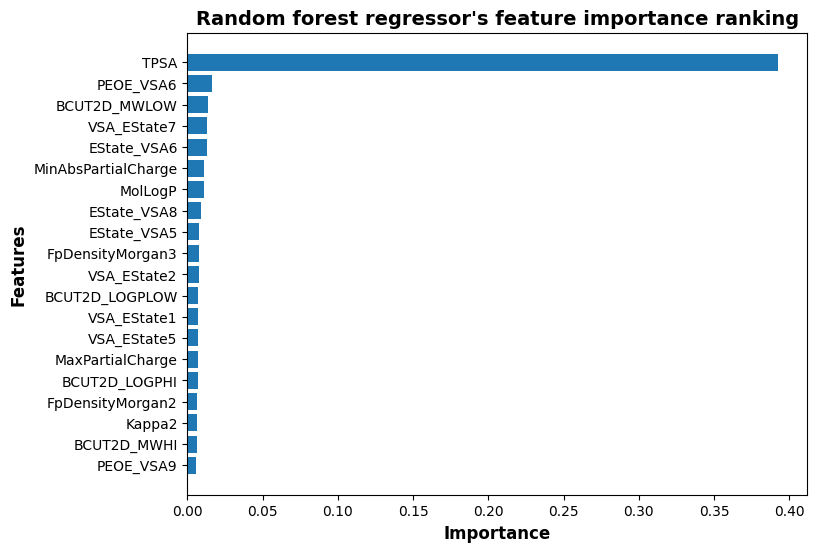

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.barh(non_zero_importance_df['Features'],
         non_zero_importance_df['Importance'])

ax.invert_yaxis()  #Flip the y-axis so the most important feature is on the top

plt.xlabel('Importance', weight='bold', fontsize=12)
plt.ylabel('Features', weight='bold', fontsize=12)
plt.title("Random forest regressor's feature importance ranking",
          weight='bold', fontsize=14)

plt.savefig(
    r'model_outputs\random_forest_regressor\importance_ranking_vertical.png',
    dpi=600,
    bbox_inches='tight'
)

plt.show()

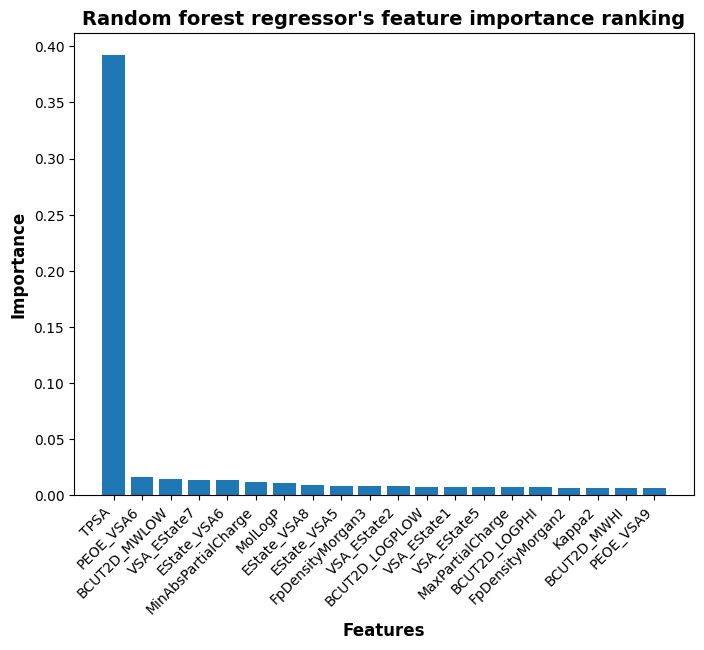

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
plt.bar(non_zero_importance_df['Features'],
        non_zero_importance_df['Importance'])

plt.xticks(rotation=45, ha='right')

plt.xlabel('Features', weight='bold', fontsize=12)
plt.ylabel('Importance', weight='bold', fontsize=12)
plt.title("Random forest regressor's feature importance ranking",
          weight='bold', fontsize=14)

plt.savefig(
    r'model_outputs\random_forest_regressor\importance_ranking_horizontal.png',
    dpi=600,
    bbox_inches='tight'
)

plt.show()

Top most important feature is the TPSA (topological polar surface area),
which indicates the drug's polarity. This make sense because the drug
polarity should dramatically influence its ability to pass through BBB.

## Classification